In [40]:
import pandas as pd

# 读取CSV文件
df_gdfhjc = pd.read_csv('gdfhjc.csv', dtype=str)
df_fydyc = pd.read_csv('fydyc.csv', dtype=str)
df_flgd = pd.read_csv('flgd.csv', dtype=str)

# 合并数据框
# 首先，将gdfhjc与fydyc合并
df_merge1 = pd.merge(df_gdfhjc, df_fydyc, on=['日期', '时间'], how='inner')
# 接着，将上一步的合并结果与flgd合并
df_final = pd.merge(df_merge1, df_flgd, on=['日期', '时间'], how='inner')

# 定义你想保留的列名列表
columns_to_keep = ['日期', '时间',  '预测时的日期','风电预测', '风力发电',  '光伏预测', '光伏发电', '供电预测','供电负荷值']

# 将日期字符串转换为datetime类型
df_final['日期'] = pd.to_datetime(df_final['日期'], format='%Y%m%d')
df_final['预测时的日期'] = pd.to_datetime(df_final['预测时的日期'], format='%Y%m%d')


# 使用loc[]来选择这些列
df_final = df_final.loc[:, columns_to_keep]

# 计算日期差异，并将结果转换为天数
df_final['间隔天数'] = (df_final['日期'] - df_final['预测时的日期']).dt.days

# 将'间隔天数'列移动到'预测时的日期'之后
# 首先获取列名列表
cols = df_final.columns.tolist()

# 确定'预测时的日期'的位置
pred_date_index = cols.index('预测时的日期')

# 重新排列列，将'间隔天数'插入到'预测时的日期'之后
cols = cols[:pred_date_index+1] + ['间隔天数'] + cols[pred_date_index+1:-1]

# 应用新的列顺序
df_final = df_final[cols]

# 保存最终结果为新的CSV文件
df_final.to_csv('merged_result.csv', index=False)
print("合并完成，结果已保存为merged_result.csv")

# 风力
df_wind = df_final[['间隔天数', '风电预测', '风力发电']]
df_wind.columns = ['间隔天数', '预测值', '实际值']
df_wind = df_wind.dropna()  # 去除含有空值的行
df_wind.to_csv('风力.csv', index=False)

# 光伏
df_pv = df_final[['间隔天数', '光伏预测', '光伏发电']]
df_pv.columns = ['间隔天数', '预测值', '实际值']
df_pv = df_pv.dropna()  # 去除含有空值的行
df_pv.to_csv('光伏.csv', index=False)

# 供电
df_supply = df_final[['间隔天数', '供电预测', '供电负荷值']]
df_supply.columns = ['间隔天数', '预测值', '实际值']
df_supply = df_supply.dropna()  # 去除含有空值的行
df_supply.to_csv('供电.csv', index=False)

print("三个CSV文件已生成并清理：风力.csv, 光伏.csv, 供电.csv")


合并完成，结果已保存为merged_result.csv
三个CSV文件已生成并清理：风力.csv, 光伏.csv, 供电.csv


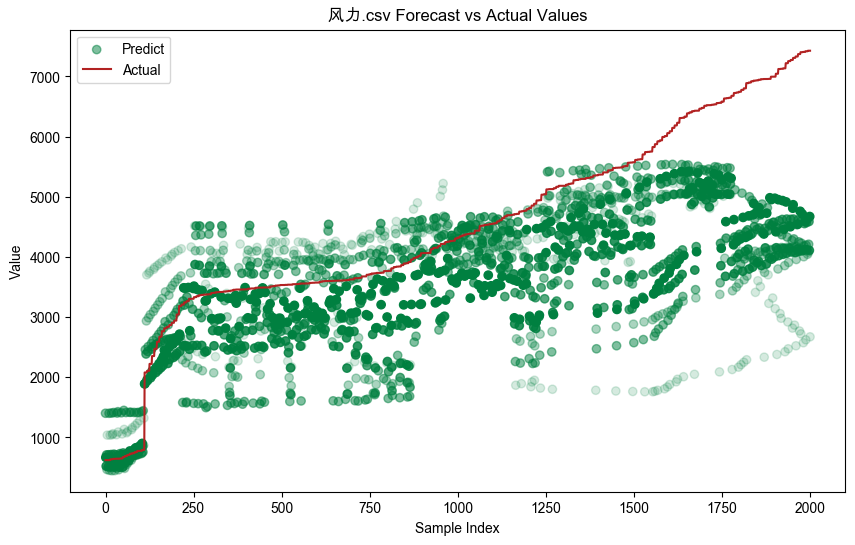

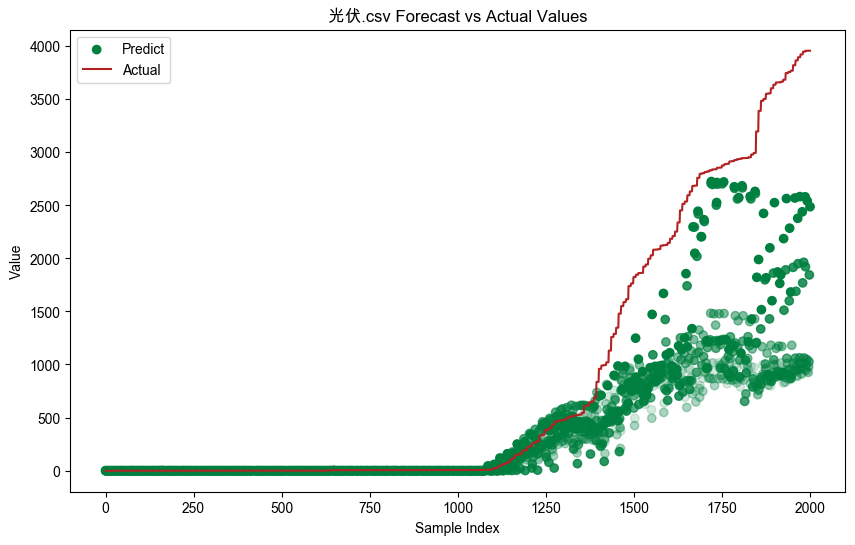

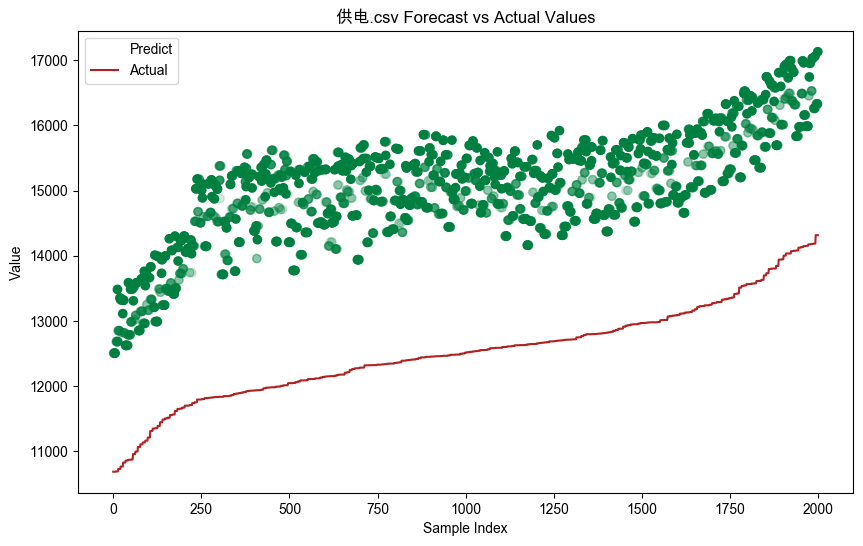

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义一个函数来读取数据、处理数据、并绘制散点图和线图
def plot_data(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)[8000:10000]

    # 将预测值、实际值和间隔天数转换为数值类型
    df['预测值'] = pd.to_numeric(df['预测值'], errors='coerce')
    df['实际值'] = pd.to_numeric(df['实际值'], errors='coerce')
    df['间隔天数'] = pd.to_numeric(df['间隔天数'], errors='coerce')

    # 根据实际值排序
    df_sorted = df.sort_values(by='实际值')
    df_sorted.reset_index(drop=True, inplace=True)

    # 标准化间隔天数到0-1范围，用作透明度
    alpha_values = 1 - (df_sorted['间隔天数'] - df_sorted['间隔天数'].min()) / (df_sorted['间隔天数'].max() - df_sorted['间隔天数'].min())

    # 绘制预测值散点图，透明度随间隔天数增加，使用指定的RGB颜色
    plt.figure(figsize=(10, 6))
    plt.scatter(df_sorted.index, df_sorted['预测值'], color='#008040', alpha=alpha_values, label='Predict')

    # 绘制实际值线图，使用柔和的颜色
    plt.plot(df_sorted.index, df_sorted['实际值'], color='#B22222', label='Actual')

    # 添加图例、标题和轴标签
    plt.legend()
    plt.title(f'{file_name} Forecast vs Actual Values')
    plt.xlabel('Sample Index')
    plt.ylabel('Value')

    # 显示图形
    plt.show()

# 对每个CSV文件绘制散点图和线图
plot_data('风力.csv')
plot_data('光伏.csv')
plot_data('供电.csv')


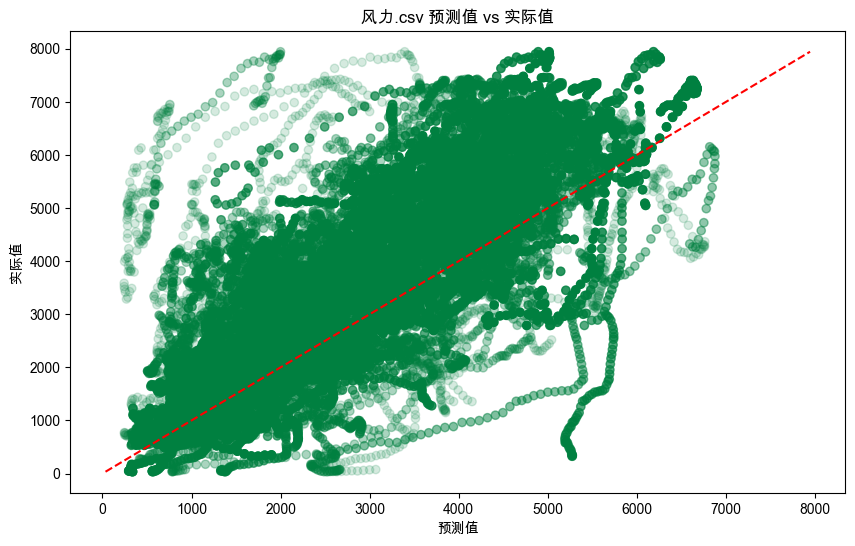

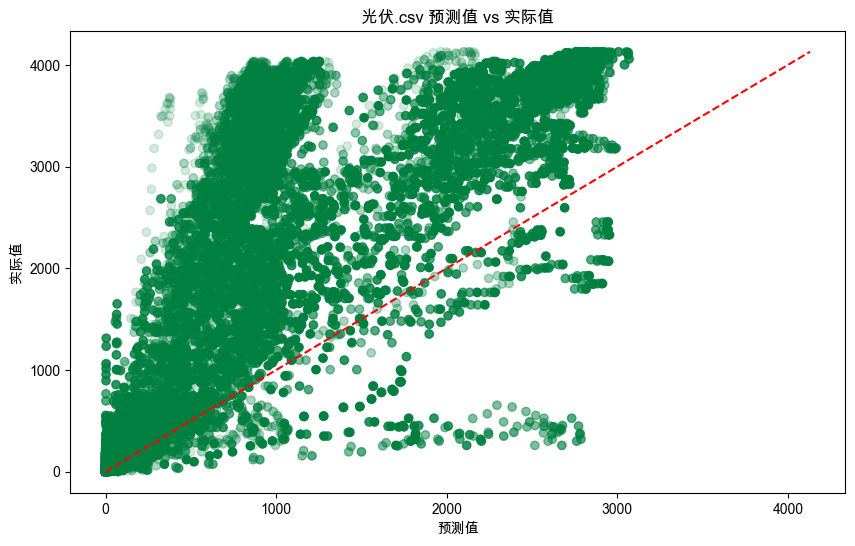

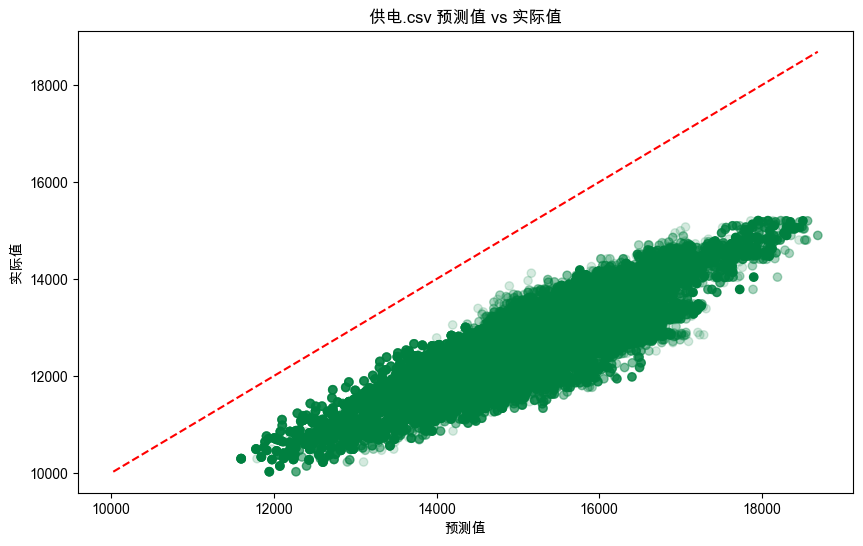

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 设置matplotlib配置参数以支持中文显示
plt.rcParams['font.family'] = ['Arial Unicode MS']  # MacOS系统可用
# plt.rcParams['font.family'] = ['SimHei']  # Windows系统可用
plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号

# 定义一个函数来读取数据、处理数据，并绘制预测值与实际值的散点图
def plot_prediction_vs_actual(file_name):
    # 读取CSV文件
    df = pd.read_csv(file_name, dtype=str)

    # 将预测值、实际值和间隔天数转换为数值类型
    df['预测值'] = pd.to_numeric(df['预测值'], errors='coerce')
    df['实际值'] = pd.to_numeric(df['实际值'], errors='coerce')
    df['间隔天数'] = pd.to_numeric(df['间隔天数'], errors='coerce')

    # 标准化间隔天数到0-1范围，用作点的透明度
    alpha_values = 1 - (df['间隔天数'] - df['间隔天数'].min()) / (df['间隔天数'].max() - df['间隔天数'].min())

    # 绘制预测值与实际值的散点图，透明度随间隔天数增加
    plt.figure(figsize=(10, 6))
    plt.scatter(df['预测值'], df['实际值'], color='#008040', alpha=alpha_values)

    # 添加图例、标题和轴标签
    plt.title(f'{file_name} 预测值 vs 实际值')
    plt.xlabel('预测值')
    plt.ylabel('实际值')

    # 绘制对角线，表示完美预测的位置
    max_value = max(df['预测值'].max(), df['实际值'].max())
    min_value = min(df['预测值'].min(), df['实际值'].min())
    plt.plot([min_value, max_value], [min_value, max_value], 'r--')

    # 显示图形
    plt.show()

# 对每个CSV文件绘制预测值与实际值的散点图
plot_prediction_vs_actual('风力.csv')
plot_prediction_vs_actual('光伏.csv')
plot_prediction_vs_actual('供电.csv')


In [1]:
import pandas as pd

def split_train_valid_csv(csv_file):
    # 读取 CSV 文件
    df = pd.read_csv(csv_file)

    # 将数据划分为训练集和验证集
    train_size = int(0.9 * len(df))
    train_df = df.iloc[:train_size]
    valid_df = df.iloc[train_size:]

    # 保存训练集和验证集为新的 CSV 文件
    train_df.to_csv(f'{csv_file.split(".")[0]}_train.csv', index=False)
    valid_df.to_csv(f'{csv_file.split(".")[0]}_valid.csv', index=False)

    print(f"Saved '{csv_file.split('.')[0]}_train.csv' and '{csv_file.split('.')[0]}_valid.csv'")
    
split_train_valid_csv('风力.csv')
split_train_valid_csv('光伏.csv')
split_train_valid_csv('供电.csv')

Saved '风力_train.csv' and '风力_valid.csv'
Saved '光伏_train.csv' and '光伏_valid.csv'
Saved '供电_train.csv' and '供电_valid.csv'
